In [1]:
import hickle as hkl
import os
import numpy as np
import sys
sys.path.append('..')

from keras import backend as K
from src.prednet import PredNet


import matplotlib.pyplot as plt
from src.data_utils import SequenceGenerator
np.random.seed(42)

DATA_DIR = '../sat_hkl'
WEIGHTS_DIR = '../sat_weight'

Using TensorFlow backend.


In [2]:
sat_train_file = '../data/features/mini_X_train.hkl'
sat_X = hkl.load(sat_train_file)
sat_train_sources = '../data/features/mini_sources_train.hkl'
sat_val_file = '../data/features/mini_X_val.hkl'
sat_val_sources = '../data/features/mini_sources_train.hkl'

nt = 96//4
batch_size = 4
n_channels, im_height, im_width = (1, 168, 128)
input_shape = (n_channels, im_height, im_width) if K.image_data_format(
) == 'channels_first' else (im_height, im_width, n_channels)
print(input_shape)
stack_sizes = (n_channels, 48, 96, 192)
R_stack_sizes = stack_sizes
A_filt_sizes = (3, 3, 3)
Ahat_filt_sizes = (3, 3, 3, 3)
R_filt_sizes = (3, 3, 3, 3)

# weighting for each layer in final loss; "L_0" model:  [1, 0, 0, 0], "L_all": [1, 0.1, 0.1, 0.1]
layer_loss_weights = np.array([1., 0., 0., 0.])
layer_loss_weights = np.expand_dims(layer_loss_weights, 1)
# nt = 10  # number of timesteps used for sequences in training
# equally weight all timesteps except the first
time_loss_weights = 1. / (nt - 1) * np.ones((nt, 1))
time_loss_weights[0] = 0

(168, 128, 1)


(1392, 168, 128, 1)
(168, 128, 1)


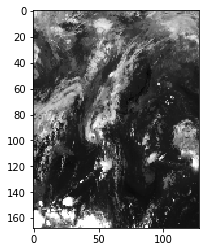

In [3]:
print(sat_X.shape)
print(sat_X[0].shape)
plt.figure(figsize=(8,4))
plt.imshow(sat_X[0].reshape(168, 128), 'gray')
plt.show()

In [4]:
prednet = PredNet(stack_sizes, R_stack_sizes,
                  A_filt_sizes, Ahat_filt_sizes, R_filt_sizes,
                  output_mode='error', return_sequences=True)

In [5]:
from keras.layers import Input, Dense, Flatten
from keras.layers import TimeDistributed
from keras.models import Model

inputs = Input(shape=(nt,) + input_shape)
errors = prednet(inputs)  # errors will be (batch_size, nt, nb_layers)
errors_by_time = TimeDistributed(Dense(1, trainable=False), weights=[
                                 layer_loss_weights, np.zeros(1)], trainable=False)(errors)  # calculate weighted error by layer
errors_by_time = Flatten()(errors_by_time)  # will be (batch_size, nt)
final_errors = Dense(1, weights=[time_loss_weights, np.zeros(
    1)], trainable=False)(errors_by_time)  # weight errors by time
model = Model(inputs=inputs, outputs=final_errors)
model.compile(loss='mean_absolute_error', optimizer='adam')


In [6]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24, 168, 128, 1)   0         
_________________________________________________________________
pred_net_1 (PredNet)         (None, 24, 4)             6909818   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 24, 1)             5         
_________________________________________________________________
flatten_1 (Flatten)          (None, 24)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 6,909,848
Trainable params: 6,909,818
Non-trainable params: 30
_________________________________________________________________


In [7]:
train_generator = SequenceGenerator(
    sat_train_file, sat_train_sources, nt, batch_size=batch_size, shuffle=True)
N_seq_val = 100  # number of sequences to use for validation
val_generator = SequenceGenerator(
    sat_val_file, sat_val_sources, nt, batch_size=batch_size, N_seq=N_seq_val)

In [ ]:
# start with lr of 0.001 and then drop to 0.0001 after 75 epochs
def lr_schedule(epoch): return 0.001 if epoch < 75 else 0.0001
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
save_model = True  # if weights will be saved

samples_per_epoch = 500
nb_epoch = 5

weights_file = os.path.join(WEIGHTS_DIR, 'prednet_sat_weights_.hdf5')
json_file = os.path.join(WEIGHTS_DIR, 'prednet_sat_model_.json')

callbacks = [LearningRateScheduler(lr_schedule)]
if save_model:
    if not os.path.exists(WEIGHTS_DIR):
        os.mkdir(WEIGHTS_DIR)
    callbacks.append(ModelCheckpoint(filepath=weights_file,
                                     monitor='val_loss', save_best_only=True))

history = model.fit_generator(train_generator, samples_per_epoch / batch_size, nb_epoch, callbacks=callbacks,
                              validation_data=val_generator, validation_steps=N_seq_val / batch_size)

if save_model:
    json_string = model.to_json()
    with open(json_file, "w") as f:
        f.write(json_string)